In [20]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

CUDA available: True
PyTorch version: 2.8.0+cu128
CUDA version: 12.8


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from sklearn.model_selection import train_test_split
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

print("Tüm kütüphaneler başarıyla yüklendi!")

Tüm kütüphaneler başarıyla yüklendi!


2. Konfigürasyon ve Hiperparametreler

In [37]:
# Model ve eğitim parametreleri
HEIGHT, WIDTH = (512, 512)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
BATCH_SIZE = 16
LR = 0.001
RATIO = 0.5
SAMPLE_NUM = 2
ENCODER = 'resnet50'
WEIGHTS = 'imagenet'

print(f"Kullanılan cihaz: {DEVICE}")
print(f"Görüntü boyutları: {HEIGHT}x{WIDTH}")
print(f"Epoch sayısı: {EPOCHS}")
print(f"Batch boyutu: {BATCH_SIZE}")
print(f"Öğrenme oranı: {LR}")
print(f"Encoder: {ENCODER}")

Kullanılan cihaz: cuda
Görüntü boyutları: 512x512
Epoch sayısı: 50
Batch boyutu: 16
Öğrenme oranı: 0.001
Encoder: resnet50


3. Veri Yükleme ve İşleme Sınıfı

In [38]:
class Load_Data(Dataset):
    """
    Uydu görüntüleri ve maskelerini yüklemek için özel Dataset sınıfı.
    """
    def __init__(self, image_list, mask_list):
        super().__init__()
        self.images_list = image_list
        self.mask_list = mask_list
        self.len = len(image_list)
        self.transform = A.Compose([
            A.Resize(HEIGHT, WIDTH),
            A.HorizontalFlip(),
            # A.RandomBrightnessContrast(p=0.5),
            # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        
    def __getitem__(self, idx):
        img = Image.open(self.images_list[idx])
        mask = Image.open(self.mask_list[idx]).convert('L')
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32)

        mask = np.expand_dims(mask, axis=0)
        mask = mask / 255.0
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask
    
    def __len__(self):
        return self.len

print("Load_Data sınıfı tanımlandı!")

Load_Data sınıfı tanımlandı!


4. Model Tanımı

In [39]:
class SegmentationModel(nn.Module):
    """
    segmentation_models_pytorch kullanarak U-Net tabanlı segmentasyon modeli.
    """
    def __init__(self):
        super().__init__()
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1, loss2
        return logits

print("SegmentationModel sınıfı tanımlandı!")

# Model örneği oluştur ve test et
test_model = SegmentationModel()
print(f"Model parametre sayısı: {sum(p.numel() for p in test_model.parameters()):,}")

SegmentationModel sınıfı tanımlandı!
Model parametre sayısı: 32,521,105


5. Eğitim ve Değerlendirme Fonksiyonları

In [40]:
def train_fn(data_loader, model, optimizer):
    """Eğitim fonksiyonu"""
    model.train()
    total_diceloss = 0.0
    total_bceloss = 0.0
    for images, masks in tqdm(data_loader, desc="Eğitim"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits, diceloss, bceloss = model(images, masks)
        # İki loss'u birleştir ve tek backward çağrısı yap
        loss = diceloss + bceloss
        loss.backward()
        optimizer.step()
        total_diceloss += diceloss.item()
        total_bceloss += bceloss.item()
        
    return total_diceloss / len(data_loader), total_bceloss / len(data_loader)

def eval_fn(data_loader, model):
    """Değerlendirme fonksiyonu"""
    model.eval()
    total_diceloss = 0.0
    total_bceloss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Değerlendirme"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, diceloss, bceloss = model(images, masks)
            total_diceloss += diceloss.item()
            total_bceloss += bceloss.item()
                
    return total_diceloss / len(data_loader), total_bceloss / len(data_loader)

print("Eğitim ve değerlendirme fonksiyonları tanımlandı!")

Eğitim ve değerlendirme fonksiyonları tanımlandı!


6. Görselleştirme Fonksiyonu

In [41]:
def visualize_predictions(model, data_loader):
    """
    Modelden tek bir örnek tahminini görselleştirir.
    """
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(data_loader))
        image = images[SAMPLE_NUM].to(DEVICE)
        mask = masks[SAMPLE_NUM]

        logits_mask = model(image.unsqueeze(0))
        pred_mask = torch.sigmoid(logits_mask)
        pred_mask = (pred_mask > RATIO) * 1.0
        
        f, axarr = plt.subplots(1, 3, figsize=(15, 5))
        axarr[0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        axarr[0].set_title('Orijinal Görüntü')
        axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
        axarr[1].set_title('Gerçek Maske')
        axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1, 2, 0)))
        axarr[2].set_title('Tahmin Edilen Maske')
        plt.tight_layout()
        plt.show()

print("Görselleştirme fonksiyonu tanımlandı!")

Görselleştirme fonksiyonu tanımlandı!


7. Veri Yükleme ve Hazırlama

In [42]:
# Veri yollarını tanımla
X = sorted(glob.glob('/tf/TOB/dataset/Images/*'))
y = sorted(glob.glob('/tf/TOB/dataset/Masks/*'))

# Veri yollarının geçerli olup olmadığını kontrol et
if not X or not y:
    print("Hata: Görüntü veya maske bulunamadı. Lütfen dosya yollarını kontrol edin.")
else:
    print(f"Toplam görüntü sayısı: {len(X)}")
    print(f"Toplam maske sayısı: {len(y)}")
    print(f"İlk görüntü yolu: {X[0]}")
    print(f"İlk maske yolu: {y[0]}")

Toplam görüntü sayısı: 2841
Toplam maske sayısı: 2841
İlk görüntü yolu: /tf/TOB/dataset/Images/water_body_1.jpg
İlk maske yolu: /tf/TOB/dataset/Masks/water_body_1.jpg


8. DataLoader Kurulumu

In [43]:
# Veri bölme ve DataLoader kurulumu
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

train_dataset = Load_Data(X_train, y_train)
valid_dataset = Load_Data(X_val, y_val)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # num_workers için daha iyi bir uygulama kullan
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

print(f"Eğitim seti boyutu: {len(train_dataset)}")
print(f"Doğrulama seti boyutu: {len(valid_dataset)}")
print(f"Eğitim batch sayısı: {len(train_loader)}")
print(f"Doğrulama batch sayısı: {len(valid_loader)}")

Eğitim seti boyutu: 2556
Doğrulama seti boyutu: 285
Eğitim batch sayısı: 160
Doğrulama batch sayısı: 18


9. Model, Optimizer ve Loss Başlatma

In [44]:
# Model oluştur ve cihaza taşı
model = SegmentationModel()
model.to(DEVICE)

# Optimizer tanımla
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Model kaydetme dizini oluştur
model_save_dir = f"/tf/TOB/{ENCODER}_unet"
os.makedirs(model_save_dir, exist_ok=True)

print(f"Model {DEVICE} cihazına taşındı")
print(f"Model kaydetme dizini: {model_save_dir}")
print(f"Optimizer: {type(optimizer).__name__}")
print(f"Öğrenme oranı: {LR}")

Model cuda cihazına taşındı
Model kaydetme dizini: /tf/TOB/resnet50_unet
Optimizer: SGD
Öğrenme oranı: 0.001


10. Eğitim Döngüsü

In [45]:
# Eğitim döngüsü
best_val_dice_loss = np.inf
train_losses = []
val_losses = []

print("Eğitim başlıyor...")
print("=" * 50)

for i in range(EPOCHS):
    print(f"\nEpoch {i+1}/{EPOCHS}")
    print("-" * 30)
    
    # Eğitim ve değerlendirme
    train_dice_loss, train_bce_loss = train_fn(train_loader, model, optimizer)
    valid_dice_loss, valid_bce_loss = eval_fn(valid_loader, model)
    
    # Loss'ları kaydet
    train_losses.append((train_dice_loss, train_bce_loss))
    val_losses.append((valid_dice_loss, valid_bce_loss))
    
    print(f'Eğitim Loss --> Dice: {train_dice_loss:.5f} BCE: {train_bce_loss:.5f}')
    print(f'Doğrulama Loss --> Dice: {valid_dice_loss:.5f} BCE: {valid_bce_loss:.5f}')
    
    # En iyi modeli kaydet
    if valid_dice_loss < best_val_dice_loss:
        save_path = os.path.join(model_save_dir, f"model_{valid_dice_loss:.5f}dice.pt")
        torch.save(model.state_dict(), save_path)
        print(f'Model kaydedildi: {save_path}')
        best_val_dice_loss = valid_dice_loss

print("\nEğitim tamamlandı!")

Eğitim başlıyor...

Epoch 1/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]


Eğitim Loss --> Dice: 0.41295 BCE: 0.48450
Doğrulama Loss --> Dice: 0.33260 BCE: 0.36322
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.33260dice.pt

Epoch 2/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.68it/s]


Eğitim Loss --> Dice: 0.26747 BCE: 0.33972
Doğrulama Loss --> Dice: 0.25923 BCE: 0.30676
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.25923dice.pt

Epoch 3/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.75it/s]


Eğitim Loss --> Dice: 0.23782 BCE: 0.31548
Doğrulama Loss --> Dice: 0.22569 BCE: 0.28302
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.22569dice.pt

Epoch 4/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.77it/s]


Eğitim Loss --> Dice: 0.22184 BCE: 0.29804
Doğrulama Loss --> Dice: 0.21818 BCE: 0.26885
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.21818dice.pt

Epoch 5/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]


Eğitim Loss --> Dice: 0.21011 BCE: 0.28369
Doğrulama Loss --> Dice: 0.20629 BCE: 0.26210
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.20629dice.pt

Epoch 6/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.72it/s]


Eğitim Loss --> Dice: 0.20663 BCE: 0.27893
Doğrulama Loss --> Dice: 0.20763 BCE: 0.26585

Epoch 7/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.73it/s]


Eğitim Loss --> Dice: 0.19052 BCE: 0.26294
Doğrulama Loss --> Dice: 0.19960 BCE: 0.25423
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.19960dice.pt

Epoch 8/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.78it/s]


Eğitim Loss --> Dice: 0.18829 BCE: 0.26009
Doğrulama Loss --> Dice: 0.19360 BCE: 0.24488
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.19360dice.pt

Epoch 9/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.72it/s]


Eğitim Loss --> Dice: 0.18223 BCE: 0.24941
Doğrulama Loss --> Dice: 0.19359 BCE: 0.25039
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.19359dice.pt

Epoch 10/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.68it/s]


Eğitim Loss --> Dice: 0.17598 BCE: 0.24389
Doğrulama Loss --> Dice: 0.18493 BCE: 0.24153
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.18493dice.pt

Epoch 11/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.68it/s]


Eğitim Loss --> Dice: 0.16842 BCE: 0.23623
Doğrulama Loss --> Dice: 0.17963 BCE: 0.24244
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.17963dice.pt

Epoch 12/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.77it/s]


Eğitim Loss --> Dice: 0.16544 BCE: 0.22993
Doğrulama Loss --> Dice: 0.18381 BCE: 0.24808

Epoch 13/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:16<00:00,  1.08it/s]


Eğitim Loss --> Dice: 0.15992 BCE: 0.22360
Doğrulama Loss --> Dice: 0.17561 BCE: 0.23697
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.17561dice.pt

Epoch 14/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.77it/s]


Eğitim Loss --> Dice: 0.15726 BCE: 0.22089
Doğrulama Loss --> Dice: 0.17837 BCE: 0.24750

Epoch 15/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.66it/s]


Eğitim Loss --> Dice: 0.15322 BCE: 0.21440
Doğrulama Loss --> Dice: 0.17540 BCE: 0.23737
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.17540dice.pt

Epoch 16/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.75it/s]


Eğitim Loss --> Dice: 0.14798 BCE: 0.20730
Doğrulama Loss --> Dice: 0.18226 BCE: 0.24380

Epoch 17/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.72it/s]


Eğitim Loss --> Dice: 0.14960 BCE: 0.20672
Doğrulama Loss --> Dice: 0.17417 BCE: 0.23808
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.17417dice.pt

Epoch 18/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.79it/s]


Eğitim Loss --> Dice: 0.13946 BCE: 0.19555
Doğrulama Loss --> Dice: 0.16277 BCE: 0.24807
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.16277dice.pt

Epoch 19/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.78it/s]


Eğitim Loss --> Dice: 0.13809 BCE: 0.19282
Doğrulama Loss --> Dice: 0.17372 BCE: 0.24338

Epoch 20/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.78it/s]


Eğitim Loss --> Dice: 0.12902 BCE: 0.18489
Doğrulama Loss --> Dice: 0.16943 BCE: 0.25272

Epoch 21/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.66it/s]


Eğitim Loss --> Dice: 0.13059 BCE: 0.18430
Doğrulama Loss --> Dice: 0.17129 BCE: 0.24651

Epoch 22/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.69it/s]


Eğitim Loss --> Dice: 0.12640 BCE: 0.17903
Doğrulama Loss --> Dice: 0.16489 BCE: 0.24622

Epoch 23/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]


Eğitim Loss --> Dice: 0.12470 BCE: 0.17694
Doğrulama Loss --> Dice: 0.16290 BCE: 0.24076

Epoch 24/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.73it/s]


Eğitim Loss --> Dice: 0.12002 BCE: 0.17215
Doğrulama Loss --> Dice: 0.16199 BCE: 0.24876
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.16199dice.pt

Epoch 25/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.71it/s]


Eğitim Loss --> Dice: 0.11670 BCE: 0.16545
Doğrulama Loss --> Dice: 0.16391 BCE: 0.24275

Epoch 26/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.80it/s]


Eğitim Loss --> Dice: 0.11447 BCE: 0.16363
Doğrulama Loss --> Dice: 0.15985 BCE: 0.25430
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15985dice.pt

Epoch 27/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.73it/s]


Eğitim Loss --> Dice: 0.11186 BCE: 0.16113
Doğrulama Loss --> Dice: 0.16129 BCE: 0.25386

Epoch 28/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.73it/s]


Eğitim Loss --> Dice: 0.11068 BCE: 0.15818
Doğrulama Loss --> Dice: 0.16652 BCE: 0.25061

Epoch 29/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.75it/s]


Eğitim Loss --> Dice: 0.10693 BCE: 0.15306
Doğrulama Loss --> Dice: 0.15875 BCE: 0.25289
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15875dice.pt

Epoch 30/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.75it/s]


Eğitim Loss --> Dice: 0.10845 BCE: 0.15454
Doğrulama Loss --> Dice: 0.15851 BCE: 0.24476
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15851dice.pt

Epoch 31/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]


Eğitim Loss --> Dice: 0.10473 BCE: 0.15147
Doğrulama Loss --> Dice: 0.15894 BCE: 0.25231

Epoch 32/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]


Eğitim Loss --> Dice: 0.10305 BCE: 0.14704
Doğrulama Loss --> Dice: 0.15633 BCE: 0.24698
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15633dice.pt

Epoch 33/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.71it/s]


Eğitim Loss --> Dice: 0.10353 BCE: 0.14863
Doğrulama Loss --> Dice: 0.16043 BCE: 0.24923

Epoch 34/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.78it/s]


Eğitim Loss --> Dice: 0.09954 BCE: 0.14348
Doğrulama Loss --> Dice: 0.15395 BCE: 0.24377
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15395dice.pt

Epoch 35/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.77it/s]


Eğitim Loss --> Dice: 0.09916 BCE: 0.14402
Doğrulama Loss --> Dice: 0.16023 BCE: 0.25015

Epoch 36/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.71it/s]


Eğitim Loss --> Dice: 0.09785 BCE: 0.14022
Doğrulama Loss --> Dice: 0.15119 BCE: 0.24919
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15119dice.pt

Epoch 37/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.69it/s]


Eğitim Loss --> Dice: 0.09566 BCE: 0.13846
Doğrulama Loss --> Dice: 0.15451 BCE: 0.25392

Epoch 38/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.67it/s]


Eğitim Loss --> Dice: 0.09314 BCE: 0.13576
Doğrulama Loss --> Dice: 0.15564 BCE: 0.25259

Epoch 39/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.75it/s]


Eğitim Loss --> Dice: 0.09323 BCE: 0.13441
Doğrulama Loss --> Dice: 0.15473 BCE: 0.25017

Epoch 40/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.72it/s]


Eğitim Loss --> Dice: 0.09147 BCE: 0.13385
Doğrulama Loss --> Dice: 0.15641 BCE: 0.25926

Epoch 41/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.61it/s]


Eğitim Loss --> Dice: 0.09260 BCE: 0.13322
Doğrulama Loss --> Dice: 0.15016 BCE: 0.25383
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.15016dice.pt

Epoch 42/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.63it/s]


Eğitim Loss --> Dice: 0.09084 BCE: 0.13152
Doğrulama Loss --> Dice: 0.14840 BCE: 0.24769
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.14840dice.pt

Epoch 43/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.59it/s]


Eğitim Loss --> Dice: 0.09260 BCE: 0.13356
Doğrulama Loss --> Dice: 0.15535 BCE: 0.25354

Epoch 44/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.67it/s]


Eğitim Loss --> Dice: 0.08872 BCE: 0.12858
Doğrulama Loss --> Dice: 0.15018 BCE: 0.25155

Epoch 45/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.59it/s]


Eğitim Loss --> Dice: 0.08684 BCE: 0.12712
Doğrulama Loss --> Dice: 0.14765 BCE: 0.25266
Model kaydedildi: /tf/TOB/resnet50_unet/model_0.14765dice.pt

Epoch 46/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.74it/s]


Eğitim Loss --> Dice: 0.08691 BCE: 0.12635
Doğrulama Loss --> Dice: 0.15086 BCE: 0.24846

Epoch 47/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.68it/s]


Eğitim Loss --> Dice: 0.08706 BCE: 0.12619
Doğrulama Loss --> Dice: 0.14976 BCE: 0.25269

Epoch 48/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.77it/s]


Eğitim Loss --> Dice: 0.08532 BCE: 0.12430
Doğrulama Loss --> Dice: 0.15124 BCE: 0.25233

Epoch 49/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.69it/s]


Eğitim Loss --> Dice: 0.08540 BCE: 0.12424
Doğrulama Loss --> Dice: 0.15081 BCE: 0.24648

Epoch 50/50
------------------------------


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.71it/s]

Eğitim Loss --> Dice: 0.08491 BCE: 0.12431
Doğrulama Loss --> Dice: 0.15084 BCE: 0.25683

Eğitim tamamlandı!


11. Eğitim Sonuçlarını Görselleştirme

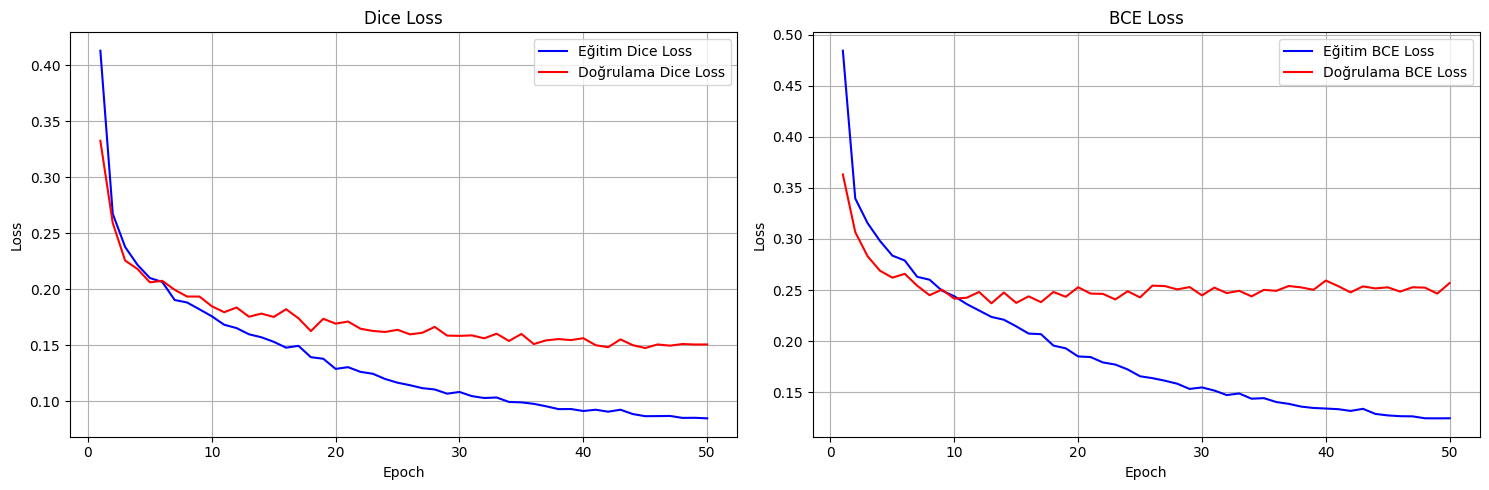

In [46]:
# Loss grafiklerini çiz
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 5))

# Dice Loss
plt.subplot(1, 2, 1)
train_dice = [loss[0] for loss in train_losses]
val_dice = [loss[0] for loss in val_losses]
plt.plot(epochs, train_dice, 'b-', label='Eğitim Dice Loss')
plt.plot(epochs, val_dice, 'r-', label='Doğrulama Dice Loss')
plt.title('Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# BCE Loss
plt.subplot(1, 2, 2)
train_bce = [loss[1] for loss in train_losses]
val_bce = [loss[1] for loss in val_losses]
plt.plot(epochs, train_bce, 'b-', label='Eğitim BCE Loss')
plt.plot(epochs, val_bce, 'r-', label='Doğrulama BCE Loss')
plt.title('BCE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

12. Model Tahminlerini Görselleştirme

Örnek tahmin görselleştiriliyor...


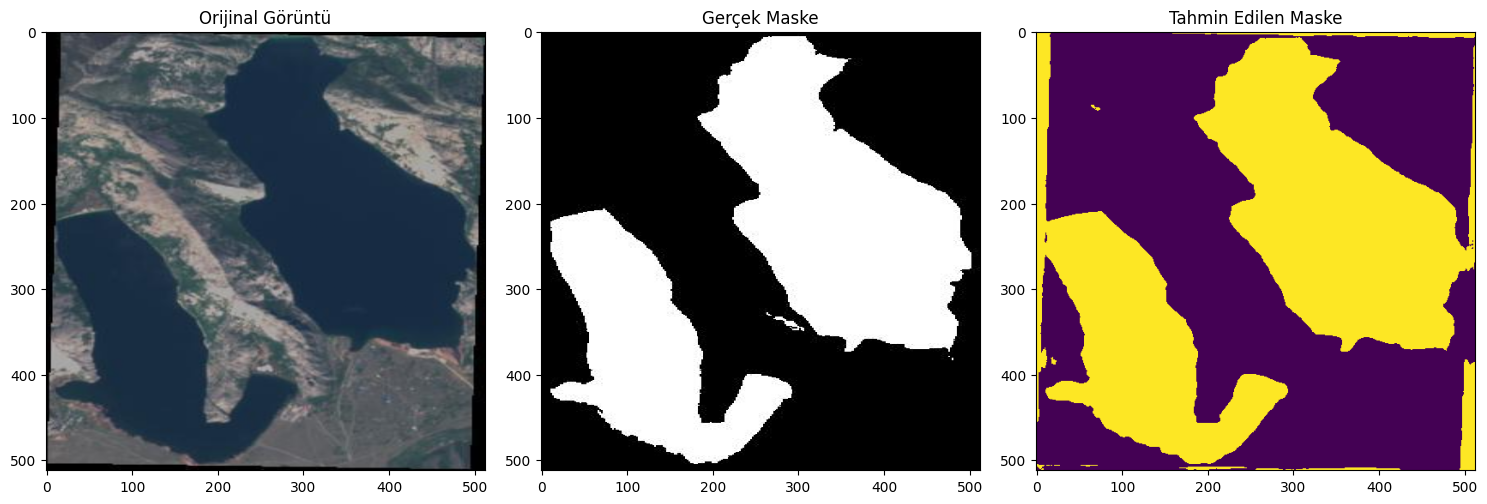

In [47]:
print("Örnek tahmin görselleştiriliyor...")
visualize_predictions(model, valid_loader)

13. Model Performans Değerlendirmesi

In [48]:
# Final model performansını değerlendir
print("Final model performansı değerlendiriliyor...")
final_dice_loss, final_bce_loss = eval_fn(valid_loader, model)

print(f"\nFinal Performans:")
print(f"Dice Loss: {final_dice_loss:.5f}")
print(f"BCE Loss: {final_bce_loss:.5f}")
print(f"En iyi Dice Loss: {best_val_dice_loss:.5f}")

# Model kaydetme yollarını listele
saved_models = glob.glob(os.path.join(model_save_dir, "*.pt"))
if saved_models:
    print(f"\nKaydedilen modeller:")
    for model_path in saved_models:
        print(f"- {os.path.basename(model_path)}")
else:
    print("\nHenüz model kaydedilmedi.")

Final model performansı değerlendiriliyor...


Değerlendirme: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.66it/s]


Final Performans:
Dice Loss: 0.14943
BCE Loss: 0.25225
En iyi Dice Loss: 0.14765

Kaydedilen modeller:
- model_0.34723dice.pt
- model_0.26404dice.pt
- model_0.23516dice.pt
- model_0.21304dice.pt
- model_0.21297dice.pt
- model_0.29853dice.pt
- model_0.25741dice.pt
- model_0.24123dice.pt
- model_0.21835dice.pt
- model_0.21344dice.pt
- model_0.33260dice.pt
- model_0.25923dice.pt
- model_0.22569dice.pt
- model_0.21818dice.pt
- model_0.20629dice.pt
- model_0.19960dice.pt
- model_0.19360dice.pt
- model_0.19359dice.pt
- model_0.18493dice.pt
- model_0.17963dice.pt
- model_0.17561dice.pt
- model_0.17540dice.pt
- model_0.17417dice.pt
- model_0.16277dice.pt
- model_0.16199dice.pt
- model_0.15985dice.pt
- model_0.15875dice.pt
- model_0.15851dice.pt
- model_0.15633dice.pt
- model_0.15395dice.pt
- model_0.15119dice.pt
- model_0.15016dice.pt
- model_0.14840dice.pt
- model_0.14765dice.pt
